# Project 5: Neural Style Transfer
## Due May 2nd

## What do CNNs see?
We have used neural networks primarily for the purposes of object recognition and image segmentation, as these are perhaps their most common uses.  However, the conceptual simplicity of the problem statement belie the complexity of the models under the hood.  In particular, we can ask: why are (convolutional) neural networks so good at these tasks that we have set out for them?  What are they doing that is so different from previous techniques?

In short, neural networks work for abstract cases that would lead to failure for simpler methods.  Take "Where's Waldo" as an example.  As we saw, template matching was extremely sensitive to the quality of the template, and when Waldo appeared in a slightly different orientation, the algorithm failed abjectly.  CNNs on the other hand can recognize objects in a variety of poses, scales, etc. without difficulty.  They do this by creating a transformation of the input data (the image) that is relatively invariant to these changes, and that operates hierarchically.  For example, the first kernel(s) of a network tends to search for simple features: lines at various orientations, blobs, particular colors, and so on.  These features are in turn convolved with another set of kernels that activate on a more complex input with a larger receptive field: lines and colors become simple shapes.  At the next layer, simple shapes become something more complex: textures or anatomical features such as eyes.  Moving further up the network, eyes become pairs of eyes, pairs of eyes become faces, and faces pair with other features to become, say, a dog.  Each of these representations has some flexibility, and this flexibility when coupled with the progressively generated representation of an object of interest is what yields the capacity for convolutional neural networks to tackle objects with the capacity for abstraction similar to the human visual system.

Because this hierarchy of features is generated programatically, *we have access to every level as the network builds up its representation of an object*.  We've been interested in the final product as the input to softmax classifier, but here we will explore the internal representation of objects in neural networks through a remarkable application known as *neural style transfer*.  

## Style transfer
Style transfer is the process of creating a new image that has the style of one image (which we will call the *style image*) and the content of another (the *content image*).  Here's an example of style transfer (by a person, not a network)
<img src=chicken.jpg width=400/> 
We have a content image (the KFC logo) and a style image (the Obama Hope poster by Shephard Fairey).  Here, the literal content of the KFC logo is reproduced, but with the semantic content of the poster. 

## Neural style transfer
Neural style transfer is the procedure of performing style transfer automatically with the help of neural networks.  While a few mechanisms have been proposed to solve this problem, we will utilize the [original approach](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).  For our example, let's use the following content and style images:

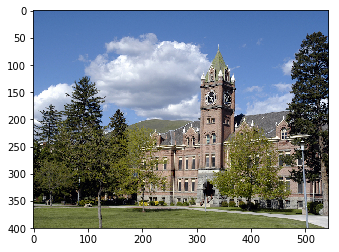

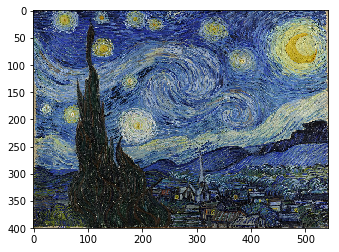

In [4]:
import keras.preprocessing as kp
import matplotlib.pyplot as plt
import numpy as np

content_path = './main_hall.jpg'
style_path = './starry_night.jpg'

# Load image to get geometry
temp_img = kp.image.load_img(content_path)
width,height = temp_img.size

# fix the number of rows, while adapting the aspect ratio
img_rows = 400
img_cols = int(width * img_rows / height)

# Load content image
content_img = kp.image.load_img(content_path, target_size=(img_rows, img_cols))
content_img = kp.image.img_to_array(content_img)
plt.figure()
plt.imshow(content_img.astype(int))

# Load style image
style_img = kp.image.load_img(style_path, target_size=(img_rows, img_cols))
style_img = kp.image.img_to_array(style_img)
plt.figure()
plt.imshow(style_img.astype(int))

plt.show()

At the most basic level, we seek to find the solution to the following problem
$$
\hat{x} = \underset{\vec{x}}{\operatorname{arg\,min}} \; \left[\alpha \mathcal{L}_{content}(\vec{p},\vec{x}) + \beta \mathcal{L}_{style}(\vec{a},\vec{x}) + \gamma \mathcal{L}_{prior}(\vec{x})\right],
$$
where $\vec{x}$ are the pixel values of the combined image, $\vec{p}$ are the pixel values of the content image, and $\vec{a}$ are the pixel values of the style image.  $\mathcal{L}_{content}(\vec{p},\vec{x})$ is the so-called *content loss*, which measures the combined image's fidelity to the content image.  $\mathcal{L}_{style}(\vec{a},\vec{x})$ is the *style loss*, which measures the combined image's stylistic similarity to the style image.  $\mathcal{L}_{prior}(\vec{x})$ is a prior which can be used to enforce constraints such as smoothness of the combined image.  $\alpha$, $\beta$, and $\gamma$ are constants that we can use to tune the relative strength of each loss function.  Thus as $\alpha/\beta\rightarrow 0$, style dominates, and vice versa.  As with most minimization problems, we will solve this by taking the derivative of this combined loss function with respect to $\vec{x}$, and using some type of gradient descent to find a minimum.  

## VGG19
Where do neural networks come in?  We use neural networks to define the losses.  While it would certainly be possible to ask the algorithm to match the content image exactly, this isn't exactly what we want: rather, we want the features to match roughly, in an abstract way.  For example, if a door shows up in the content image, we want a door to show up in the style image, but it doesn't have to be exactly straight up and down, nor does it have to have the same color.  It just needs to be door-like in a general sense.  To do this, instead of asking the algorithm to minimize the difference between the combined image and the door, we can minimize the difference of feature maps computed at some layer of a convolutional neural network between the combined and content images.

Of course we must select a neural network to use in order to make these feature representations.  In almost all instances of neural style transfer, the VGG19 network is used.  VGG19 is a fairly old network and far from the state of the art for tasks such as object recognition.  However, it almost unanimously provides the best results for neural style transfer, most likely because of its simplicity: there aren't any skip connections or other strange architectural styles, and the resulting features are thus closer to the ideal description of a neural network given above.  Packaged along with this notebook is a Keras implementation of VGG19, that also loads a set of weights pretrained on the [ImageNet](http://www.image-net.org/) dataset.  You can download the requisite weights [here](http://www.vlfeat.org/matconvnet/pretrained/#downloading-the-pre-trained-models).  (Note actually that the VGG19 provided by me is *not* the original VGG19, nor is it equivalent to the pre-trained model that is packaged with Keras: max-pooling has been replaced with average pooling, the activations have been broken out into explicit layers, and the weights are oriented such that it operates on mean-subtracted RGB images, rather than BGR.  These modifications provide better neural style transfer results.)

First, we'll need to normalize the images in the way that VGG19 expects, which means subtracting the mean pixel value of the dataset used to train it: 

In [5]:
content_img[:, :, 0] -= 103.939
content_img[:, :, 1] -= 116.779
content_img[:, :, 2] -= 123.68
content_img = np.expand_dims(content_img, axis=0)

style_img[:, :, 0] -= 103.939
style_img[:, :, 1] -= 116.779
style_img[:, :, 2] -= 123.68
style_img = np.expand_dims(style_img, axis=0)

Next, let's instantiate a VGG19 model for the content image:

Instructions for updating:
Colocations handled automatically by placer.


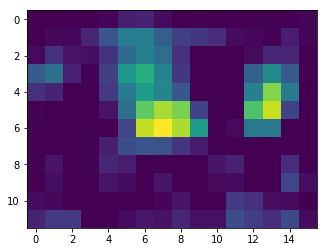

In [6]:
import vgg
import keras.backend as K
import keras.layers as kl
import keras.models as km

# Note that we'll be working quite a bit with the TensorFlow objects that underlie Keras
content_model_input = kl.Input(tensor=K.tf.Variable(content_img))

content_base_model = vgg.VGG19(input_tensor=content_model_input)
evaluator = K.function([content_base_model.input],[content_base_model.output])
feature_maps = evaluator([content_img])
plt.imshow(feature_maps[0][0,:,:,500])
plt.show()

The function defines above provides the output of the last activation in VGG19.  However, this is not the layer that we need.  Indeed, in the original neural style transfer paper, the authors found that good aesthetic properties were found by matching on the (unactivated) feature maps in the second convolution of the fourth block, called 'block4_conv2' (have a look at the VGG file if you're confused by what this means).  We can generate a new Keras model that does this for us easily:

In [7]:

# Define the layer outputs that we are interested in
content_layers = ['block4_conv2']

# Get the tensor outputs of those layers
content_outputs = [content_base_model.get_layer(n).output for n in content_layers]

# Instantiate a new model with those outputs as outputs
content_model = km.Model(inputs=content_base_model.inputs,outputs=[content_base_model.get_layer(n).output for n in content_layers])

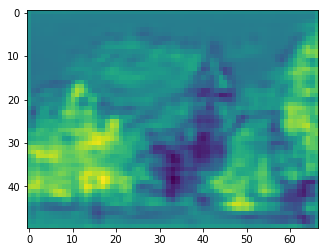

In [8]:
# This is not used any further, it's just for visualizing the features
evaluator = K.function([content_model.input],[content_model.output])
feature_maps = evaluator([content_img])
plt.imshow(feature_maps[0][0,:,:,125])
plt.show()

**We'll need a similar model for the style image.  Generate a second neural network, this time asking the model to produce as outputs the layers block1_relu1, block2_relu1, block3_relu1, block4_relu1, and block5_relu1.**

In [9]:
# Please call this second network 'style_model'

#! Change me
style_layers = ['block1_relu1', 'block2_relu1', 'block3_relu1', 'block4_relu1', 'block5_relu1']

style_base_model = vgg.VGG19(input_tensor=kl.Input(tensor=K.tf.Variable(style_img)))

#! Change me
style_model = km.Model(inputs=style_base_model.inputs,outputs=[style_base_model.get_layer(n).output for n in style_layers])

Finally, we'll need a 3rd neural network to evaluate the features of the blended image.  We'll be comparing feature maps in the blended image to the equivalent feature maps in both the content and style image, so this model will need to yield the output of block4_conv2 and the five layers stated above.  Because the input to this final model is going to be dynamic (we'll be updating as we minimize the loss), we'll provide it with a more general input type with the same shape as the content image, but with no values specified.

In [10]:
# What are we saying about the size of the input image here?
blended_model_input = kl.Input(shape=content_img.shape[1:])

**Instantiate the third neural network for the blended image as you did the content and style images, but with a concatenated list of layers as outputs and the input as specified in the cell above**

In [42]:
# Please call this third network 'blend_model'

base_model = vgg.VGG19(input_tensor=blended_model_input)

#! Change me
blend_model = km.Model(inputs=blended_model_input, outputs=[base_model.get_layer(n).output for n in (['block4_conv2'] + style_layers)])

# Separate the model outputs into those intended for comparison with the content layer and the style layer
blend_content_outputs = [blend_model.outputs[0]]
blend_style_outputs = blend_model.outputs[1:]

## Defining the content loss

Now we need to actually mathematically define the content loss.  This turns out to be rather simple: the content loss is just the (scaled) sum square error between the block4_conv2 features maps in the combined and content images:
$$
\mathcal{L}_{content}(\vec{p},\vec{x}) = \frac{1}{2 M^{\frac{1}{2}} N^{\frac{1}{2}}} \sum \left[F(\vec{x})_\ell - F(\vec{p})_\ell\right]^2,
$$
where $F(\vec{x})_\ell$ is the CNN's output at layer $\ell$.  The summation runs over all three tensor dimensions, $M$ is the image width times height, and $N$ is the image depth.

**Implement a function that computes the content loss**

In [45]:
def content_layer_loss(Fp, Fx):
    #! Change me
    _,h,w,d = Fp.get_shape()
    M =  w.value * h.value
    N = d.value
    
    err = (Fx - Fp)**2
    sse = K.tf.reduce_sum(err)
    
    loss = 1 / (2 * M ** (1/2) * N ** (1/2)) * sse
    return loss

content_loss = content_layer_loss(content_model.output,blend_content_outputs[0])

# The correct output of this function is 195710720.0
np.random.seed(0)
input_img = np.random.randn(1,img_rows,img_cols,3)
content_loss_evaluator = K.function([blend_model.input],[content_loss])
content_loss_evaluator([input_img])

[195711020.0]

## Defining the style loss

Now we need to define some metric for comparing the *style* between two images.  After watching the Ng videos, you should be aware that one way of doing this is by comparing Gram matrices.  

The Gram matrix is sort of like a sample covariance, except that instead of measuring the similarity of data points with respect to the data features (as does a covariance matrix), the Gram matrix measures the similarity of features with respect to the data points.  Stated concretely and in this context, it measure the degree to which two feature maps tend to activate together.  It is computed similarly to the covariance matrix, but with the dimensions reversed (and without the mean subtracted):
$$
G(\vec{f}) = f^T f, 
$$
where $f$ is a set of $N$ feature maps reshaped to $\mathbb{R}^{M \times N}$ (i.e. flattened along the spatial dimension), where $M$ is once again width times height and $N$ is the number of feature maps.  

**Implement a function that computes the Gram matrix**

In [27]:
def gram_matrix(f, M, N):
    f = K.tf.reshape(f, (M, N))
    G = K.tf.linalg.matmul(f, f, transpose_a=True)
    return G

# For a correctly implemented gram_matrix, the following code will produce 113934860.0
fmap = content_model.output
_,h,w,d = fmap.get_shape()
M = h*w
N = d
gram_matrix_evaluator = K.function([content_model.input],[gram_matrix(fmap,M,N)])
gram_matrix_evaluator([content_img])[0].mean()

113935430.0

Now that we have a method of computing gram matrices, we can simply compare them between images to assess whether the style metric is similar.  Note that we will do this over multiple style model layers to ensure that we are capturing stylistic similarites at a variety of spatial scales.  The style loss for a particular layer is then given as 
$$
\mathcal{L}_{style,\ell}(\vec{a},\vec{x}) = \frac{1}{4 M^2 N^2} \sum_{i,j}^N \left[ G(F(\vec{a})_\ell)_{ij} - G(F(\vec{x})_\ell)_{ij} \right]^2.
$$
In plain language, what the above says is to compute the Gram matrix at layer $\ell$ for both the style and blended images, and to compute the elementwise sum square error between them.

**Implement a function that computes the style loss for one layer**

In [37]:
def style_layer_loss(Fa, Fx):
    _, h, w, d = Fa.get_shape()
    M = h*w
    N = d
    Ga = gram_matrix(Fa, M, N)
    Gx = gram_matrix(Fx, M, N)
    
    err = (Ga - Gx)**2
    sse = K.tf.reduce_sum(err)
    
    loss = (1 / (4 * M.value ** 2 * N.value ** 2)) * sse
    return loss

style_loss_0 = style_layer_loss(style_model.output[0],blend_style_outputs[0])

# The correct output of this function is 220990.31
np.random.seed(0)
input_img = np.random.randn(1,img_rows,img_cols,3)
style_loss_evaluator = K.function([blend_model.input],[style_loss_0])
style_loss_evaluator([input_img])

[220899.6]

Finally, we'll need to add up style losses over all five layers that we wish to compute it over.  We may wish to adjust weights between different layers for different effects in the future, but for now let us just assume that each layer-wise style loss is equal to $\frac{1}{5}$

In [39]:
style_loss = 0
for i in range(5):
    style_loss += 0.2*style_layer_loss(style_model.output[i],blend_style_outputs[i])
    
# The correct output of this function is 177059700.0
np.random.seed(0)
input_img = np.random.randn(1,img_rows,img_cols,3)
style_loss_evaluator = K.function([blend_model.input],[style_loss])
style_loss_evaluator([input_img])

[174833010.0]

## Prior loss (regularization)
While this doesn't have much to do with neural networks, it's part of the problem specification.  In particular, we want to make sure that our blended image isn't too noisy.  To do this, we'll simply add a penalty on [total variation](https://en.wikipedia.org/wiki/Total_variation), which is simply the summed up absolute values of the derivatives.

In [40]:
tv_loss = K.tf.image.total_variation(blend_model.input)

## Total loss
Finally, we can add these three losses up, scaled by some arbitrary weighting factors, to get a total loss:

In [51]:
alpha = 5.0
beta = 2e3
gamma = 1e-3

total_loss = alpha*content_loss + beta*style_loss + gamma*tv_loss
    
# The correct output of this function is 1.7715756e+12
np.random.seed(0)
input_img = np.random.randn(1,img_rows,img_cols,3)
total_loss_evaluator = K.function([blend_model.input],[total_loss])
total_loss_evaluator([input_img])

[array([3.5064457e+11], dtype=float32)]

## Optimization
The blended image is the one that minimizes the loss defined above.  How do we find the minimum?  By following the gradient of the loss function "downhill".  It is important to remember that the dimensions of this problem are the RGB pixel values of the the input image.  How can we compute this gradient?  Tensorflow makes it quite easy through [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).  Note that this is essentially the same thing as backpropagation, but here we're taking the derivative of a loss defined on the intermediate layers of a neural network with respect to the inputs, versus in the normal NN learning case where we're finding the derivative of some cost function defined on network outputs with respect to the weights.  The command for computing a gradient in tensorflow is:

In [47]:
grads = K.gradients(total_loss,blend_model.input)[0]

Instructions for updating:
Use tf.cast instead.


This produces a tensor, but what we need is a function that takes our input image as an input, and outputs the loss and the gradient of the loss.  We can use the tensorflow 'function' to do this

In [49]:
loss_and_grad_evaluator = K.function([blend_model.input],[total_loss,grads])

np.random.seed(0)
input_img = np.random.randn(1,img_rows,img_cols,3)
l0,g0 = loss_and_grad_evaluator([input_img])
# Correct value of l0 is 3.5509e11
# Correct value of first element in g0 is -7.28989e2
print(l0, g0)

[3.5064457e+11] [[[[-7.24319641e+02 -1.10560669e+03 -3.49022751e+01]
   [-1.97350818e+03 -2.14280322e+03 -4.11556396e+02]
   [-1.48958398e+03 -6.96185547e+02  8.41293152e+02]
   ...
   [-8.60080811e+02 -4.34395630e+02  3.94581299e+02]
   [-6.39546143e+02 -3.94728027e+02  1.87004745e+02]
   [-1.50656845e+02 -3.38167267e+01  2.35188705e+02]]

  [[-4.55103058e+02 -5.47239380e+02  1.02608289e+03]
   [-1.97720166e+03 -1.19372693e+03  1.52960425e+03]
   [-1.44111047e+03  9.07573364e+02  3.63978906e+03]
   ...
   [-1.30198376e+03 -7.97322266e+02  6.38940308e+02]
   [-1.18155664e+03 -9.33044006e+02  1.72972336e+02]
   [-4.79270935e+02 -3.86097809e+02  1.86834488e+02]]

  [[ 2.29595673e+02  8.80485291e+02  2.46161719e+03]
   [-1.47849353e+03  8.35854858e+02  3.80422876e+03]
   [-2.32970190e+03  1.91117102e+03  5.37860791e+03]
   ...
   [-2.75785919e+02 -2.97746948e+02  1.69392200e+03]
   [-2.96648621e+02 -3.85428558e+02  1.08939771e+03]
   [-1.95383224e+02 -2.50544846e+02  4.76484863e+02]]

  .

We can now evaluate the loss and gradient for an arbitrary image input.  All that's left is to solve the minimization problem.  The authors of the original neural style transfer paper use l_bfgs.  There is a convenient implementation of this algorithm in scipy

In [79]:
import scipy.optimize as sio

class cool():
    def __init__(self):
        self.current_grad = None
    
    def f(self, input_img):
        #print(input_img.shape)
        input_img = np.reshape(input_img, (1,img_rows,img_cols,3))
        #print("img", input_img.dtype)
        #print(input_img.shape)
        loss, self.current_grad = loss_and_grad_evaluator([input_img])
        #print("grad", self.current_grad.dtype)
        return loss
    
    def grad(self, _):
        return self.current_grad.astype('float64').flatten()
        


c = cool()

#c.f(input_img)
    


sio.fmin_l_bfgs_b(c.f, input_img, c.grad, iprint=5)

KeyboardInterrupt: 

**Use this method to find the image that minimizes the total loss.  Around 500 iterations is usually sufficient to produce fully converged results.**  

A few gotchas: 1. the scipy algorithm expects a vector, while our method expects an array of size (1,height,width,3).  You'll need to do some reshaping of input and output arrays and puts the arguments to both the tensorflow function and to the scipy optimizer in the formats that they expect.  2. We have to compute the loss to compute the gradient, but the gradient of the loss doesn't change unless the loss is recomputed.  Thus, the functions that go into fmin_l_bfgs_b should be aware of that fact, and should avoid unnecessary computation.  Both (1) and (2) above can be addressed by generating a python class that have both a loss and gradient method that perform the necessary array reshapings internally, and that don't recompute the gradient once it's already been computed (stated concretely, the loss method should call "loss_and_grad_evaluator", and should return the loss while saving the gradient.  The gradient method should simply return this precomputed gradient.)

Finally, when you output the result of your optimization, you'll want to re-add the band means we extracted earlier (R=103.939, G=116.779, B=123.68), cast the array back to integer, and clip any values greater than 255 before saving.  